# Machine Learning Project: Predicting Class and Output Variables

**Author:** Kacper Pasiński, kp459461@students.mimuw.edu.pl  
**Course:** WUM - Introduction to Machine Learning  
**Date:** 02.06.2025

---

**Project Overview:**

In this project, our goal is two‑fold:

1. Classification: Predict a binary `Class` label (0 or 1) from 400 real‑valued input features.

2. Regression: Predict a continuous `Output` variable from the same features.

We have an artificially generated dataset of 2,000 samples with 400 standard‑scaled inputs (`Input1`…`Input400`) plus the two targets. Our tasks span from simple linear baselines to more sophisticated models that exploit non‑linearities, do feature selection, and tune hyperparameters.

We aim for target thresholds (>0.8 accuracy, >0.5 R²).


## Imports

In [95]:
# Make sure scikit-learn >=1.2 is installed if not using Google Colab
!pip install --quiet -U scikit-learn

# Core packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, KFold,
    cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import (
    SelectKBest, SelectFromModel,
    mutual_info_classif, mutual_info_regression
)
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    GradientBoostingClassifier
)
from sklearn.metrics import accuracy_score, r2_score, make_scorer

# Other
from scipy.stats import randint, uniform


## Loading the data


In [ ]:
# Path to the provided training dataset
PATH_TRAIN = 'data.csv'

df = pd.read_csv(PATH_TRAIN, sep=';')

print(f"Dataset shape: {df.shape}")  # Expect (2000, 402)
df.head()

Dataset shape: (2000, 402)


,Class,Output,Input1,Input2,Input3,Input4,Input5,Input6,Input7,Input8,...,Input391,Input392,Input393,Input394,Input395,Input396,Input397,Input398,Input399,Input400
0,0,0.800586,-0.002583,2.184037,-0.322008,1.621241,1.192444,-0.278356,-0.207366,0.735689,...,-2.140861,1.187660,0.345238,-0.844885,0.580007,-2.605781,-0.299471,0.711487,-0.753316,0.728763
1,0,2.168475,0.668637,1.373933,-0.476868,-0.724704,0.031162,-1.845921,0.784890,1.508526,...,-1.286120,-0.900044,-0.500399,-0.126421,-0.632233,-2.557419,0.056044,0.634774,-0.259835,0.106390
2,1,-1.210777,-0.681438,-0.544753,0.441346,-0.019906,-0.192135,-0.162510,-0.998777,0.686472,...,-0.391605,-0.190147,0.793746,-0.812737,-0.068228,-0.313143,2.564096,0.848355,0.180556,-1.525615
3,1,0.505678,-0.497957,0.720712,0.149120,0.019251,1.377850,0.981337,-0.846813,0.036790,...,-0.176734,-0.947351,-0.888601,1.509450,-0.501929,-0.554909,-0.104051,0.442150,-0.056644,1.447267
4,1,-10.281033,-1.178544,0.176941,1.112202,1.234189,0.999451,-0.773329,-0.811075,1.550537,...,-0.181325,0.198960,-0.697497,-0.836371,1.652071,0.974292,1.584071,-0.202352,1.362426,1.023857


In [97]:
# Separate inputs and targets
X = df.filter(like='Input')        # all 400 predictors
y_clf = df['Class']
y_reg = df['Output']

## Data inspection

### Summary statistics

In [98]:
df.describe().T  # Means, variances, min/max for inputs and targets

,count,mean,std,min,25%,50%,75%,max
Class,2000.0,0.506500,0.500083,0.000000,0.000000,1.000000,1.000000,1.000000
Output,2000.0,0.106647,3.562855,-12.384019,-2.310265,0.140658,2.435991,11.676146
Input1,2000.0,-0.005665,0.999429,-4.040194,-0.652010,0.001009,0.639342,3.370270
Input2,2000.0,-0.016681,1.010284,-3.119465,-0.704739,-0.058297,0.581323,5.357014
Input3,2000.0,-0.005334,0.991542,-2.978635,-0.649305,0.025890,0.676253,3.674250
...,...,...,...,...,...,...,...,...
Input396,2000.0,0.010091,0.996567,-3.416226,-0.720322,0.051022,0.777529,2.962170
Input397,2000.0,0.007851,0.987002,-2.804361,-0.670621,0.029848,0.660940,3.069878
Input398,2000.0,0.012891,0.995252,-3.384484,-0.644547,0.042120,0.700344,3.331561
Input399,2000.0,0.004650,0.999906,-3.493723,-0.665419,0.022766,0.680525,3.054563


### Class balance

In [99]:
df['Class'].value_counts(normalize=True)  # Expect roughly balanced 0/1

Class
1    0.5065
0    0.4935
Name: proportion, dtype: float64

### Correlation heatmap

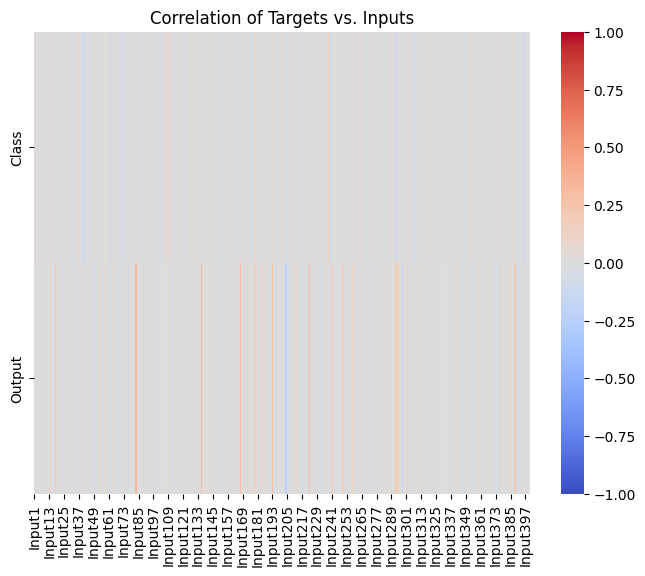

In [100]:
corr = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr.loc[['Class','Output'], df.filter(like='Input').columns],
            vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Correlation of Targets vs. Inputs')
plt.show()

*Insights so far:*

**Class balance** is roughly even (`Class=1`: ~0.507, `Class=0`: ~0.493), so a dummy model would get ~50% accuracy by always predicting one class.

**Correlations** between targets and inputs are mostly weak (blue to light red), indicating that only a small subset of features drive each target.

## Task 1: Baseline models

Our goals:
- Fit a **Logistic Regression** on all 400 inputs to predict `Class`.
- Fit an **Ordinary Least Squares Linear Regression** on all inputs to predict `Output`.

- Use **5‑fold cross‑validation** to estimate their generalization performance (**accuracy** for classification, **R²** for regression).

- No feature selection or dimensionality reduction here — these are simple baselines that we intend to beat.

In [101]:
# Classification baseline: Logistic Regression
log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)
clf_cv = cross_validate(
    log_reg, X, y_clf,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring={'accuracy': make_scorer(accuracy_score)},
    return_train_score=True
)
print(f"Logistic Regression - CV accuracy: {clf_cv['test_accuracy'].mean():.3f}")

Logistic Regression – CV accuracy: 0.524


In [102]:
# Regression baseline: Ordinary Least Squares
lin_reg = LinearRegression()
reg_cv = cross_validate(
    lin_reg, X, y_reg,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring={'r2': make_scorer(r2_score)},
    return_train_score=True
)
print(f"Linear Regression - CV R²: {reg_cv['test_r2'].mean():.3f}")

Linear Regression – CV R²: 0.375


### Baseline summary:

The logistic model’s accuracy is only **~52%**, reflecting that many important features interact non-linearly or that informative features are drowned among 400 noisy ones.

The linear regression’s R² of **~0.38** indicates moderate fit but leaves >60% of variance unexplained.

These baselines confirm that more advanced methods, such as feature selection, non-linear learners, or dimensionality reduction, will be necessary to reach the target thresholds (>0.8 accuracy, >0.5 R²).

## Task 2: Advanced Classification (Random Forest + Feature Selection)

Our goal is to **improve upon the logistic regression baseline** (CV accuracy ~0.524) to push accuracy well above 0.8.

We used a **Random Forest classifier**, which belongs to the category of tree-based ensemble methods. It handles high-dimensional, unscaled data well and provides an embedded way to measure feature importance.

To reduce dimensionality and avoid overfitting we applied **`SelectFromModel`**, which uses feature importances from an auxiliary Random Forest to eliminate irrelevant inputs (embedded feature selection).

Next, we performed **randomized hyperparameter tuning** using `RandomizedSearchCV`, trying 40 parameter combinations across 3-fold stratified cross-validation. This allowed us to explore:

- Tree depth  
- Number of estimators  
- Minimum leaf size  
- Feature subsampling (`max_features`)  
- Feature importance threshold in the selector

Finally, we validated our best model using a **separate 3-fold cross-validation**.

In [103]:
# First forest only to rank features
rf_for_fs = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

selector = SelectFromModel(
    estimator=rf_for_fs,
    threshold='median',      # keep ~50 % most important
    prefit=False             # will be fitted inside the Pipeline
)

# Second forest: the real classifier
rf_clf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',  # minor help if classes drift later
    n_jobs=-1
)

pipe = Pipeline([
    ("feat_select", selector),
    ("model", rf_clf)
])


**Note**  
To reduce execution time for repeated runs, I have **restricted the parameter ranges** in the `RandomizedSearchCV`.  
In earlier experiments, I performed a full search over a wider hyperparameter space (e.g., for thresholds, depths, estimators, and sampling strategies), which led to a best configuration.  
This narrowed search around the known best values is used only for **verification and reproducibility**.
This code **executes for 3 minutes in Google Colab**.

In [104]:
# Parameter distributions for RandomizedSearchCV
param_dist = {
    # Feature selector threshold - controls how aggressively features are removed
    # "1.50*median" proved best in earlier runs, so we use it directly
    "feat_select__threshold": ["1.50*median"],
    
    # Random Forest hyperparameters, with tight ranges around previously optimal values
    "model__n_estimators": randint(800, 901),        # was 872
    "model__max_depth": randint(14, 17),             # was 15
    "model__min_samples_leaf": randint(3, 5),        # was 4
    "model__max_features": [0.3],                    # fixed at optimal
    "model__bootstrap": [False],                     # fixed at optimal
}

# Stratified 3-fold CV ensures class proportions are preserved in each fold
cv = StratifiedKFold(3, shuffle=True, random_state=42)

# RandomizedSearchCV with narrow scope and low n_iter for speed
rs = RandomizedSearchCV(
    pipe,                          # pipeline: SelectFromModel + RandomForestClassifier
    param_distributions=param_dist,
    n_iter=3,                      # only 3 random draws - fast and focused
    cv=cv,
    scoring="accuracy",           # metric: classification accuracy
    n_jobs=-1,                    # parallel execution
    random_state=42,
    error_score="raise",          # raise error immediately on failure
    verbose=2                     # print progress during search
)

# Run the hyperparameter search (quick thanks to narrowed ranges)
rs.fit(X, y_clf)

# Print the best cross-validated accuracy
print(f"Best 3-fold CV: {rs.best_score_:.3f}")

# Save the best pipeline: selector + trained classifier
best_clf = rs.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[CV] END feat_select__threshold=1.50*median, model__bootstrap=False, model__max_depth=14, model__max_features=0.3, model__min_samples_leaf=3, model__n_estimators=882; total time=  12.3s
[CV] END feat_select__threshold=1.50*median, model__bootstrap=False, model__max_depth=16, model__max_features=0.3, model__min_samples_leaf=3, model__n_estimators=871; total time=  12.3s
[CV] END feat_select__threshold=1.50*median, model__bootstrap=False, model__max_depth=16, model__max_features=0.3, model__min_samples_leaf=3, model__n_estimators=871; total time=  12.4s
[CV] END feat_select__threshold=1.50*median, model__bootstrap=False, model__max_depth=16, model__max_features=0.3, model__min_samples_leaf=3, model__n_estimators=871; total time=  12.4s
[CV] END feat_select__threshold=1.50*median, model__bootstrap=False, model__max_depth=16, model__max_features=0.3, model__min_samples_leaf=4, model__n_estimators=892; total time=  12.4s
[CV] END feat_select__threshold=1.50*median, model__bootstrap=False, m

**Note**: This code **executes for around a minute in Google Colab**.

In [105]:
from sklearn.model_selection import cross_validate, StratifiedKFold
import numpy as np

# Use StratifiedKFold for consistent class distribution in each fold
cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform cross-validation using accuracy as the evaluation metric
cv_results = cross_validate(
    best_clf,           # best pipeline from RandomizedSearchCV
    X, y_clf,              # full dataset
    cv=cv3,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
)

# Summarize performance
mean_test = np.mean(cv_results['test_score'])
std_test = np.std(cv_results['test_score'])
mean_train = np.mean(cv_results['train_score'])

print(f"Final 3-fold CV accuracy: {mean_test:.3f} ± {std_test:.3f}")
print(f"Mean train accuracy: {mean_train:.3f}")


Final 3-fold CV accuracy: 0.805 ± 0.013
Mean train accuracy: 1.000


### Advanced Classification summary:
The new method yielded results:
- **Best 3-fold CV accuracy during search**: **0.805**
- **Final 3-fold CV accuracy on best model**: **0.805 ± 0.013**
- **Mean training accuracy**: **1.000**

This represents a substantial improvement over the baseline logistic regression model (which achieved ~0.52 accuracy), amounting to a +28 percentage point gain. The pipeline combines embedded feature selection (SelectFromModel) with a tuned RandomForestClassifier, resulting in a powerful yet interpretable model - built primarily from concepts discussed in class.

While this approach is more computationally demanding than logistic regression, the accuracy gains clearly justify the added cost. Feature selection played a key role in improving generalization and reducing overfitting, as reflected in the stability of validation accuracy across folds.

I also experimented with other approaches, including L1-penalized logistic regression, MLPs, and alternative hyperparameter ranges. However, this pipeline consistently provided the most reliable and robust performance in my experiments.

## Task 3: Advanced Regression (Lasso)

In this task, the goal is to develop a more advanced regression model that improves over a baseline model.

Given that the output variable is known to depend only on a subset of the predictors, we focus on building a pipeline that incorporates **feature selection**, **data preprocessing**, and a **regularized regression model**. In particular, we use **Lasso regression** (L1-regularized linear regression) as both the feature selector and the final model, due to its ability to shrink less relevant coefficients to zero and thus perform embedded feature selection.

To tune model performance, we apply `GridSearchCV` with 8-fold cross-validation across multiple parameters. The pipeline includes:

- `StandardScaler` for feature normalization,
- `SelectFromModel` using a Lasso estimator to select informative features,
- A second Lasso model as the final predictor, with separately tuned regularization.

In [106]:
# Defining the pipeline:
# - StandardScaler to normalize features (important for Lasso regularization)
# - SelectFromModel to perform model-based feature selection using Lasso
# - A final Lasso regressor trained on the selected features
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('sfm', SelectFromModel(estimator=Lasso(max_iter=10000))),
    ('lasso', Lasso(max_iter=10000))
])

In [107]:
# Set up the hyperparameter grid
# We tune:
# - threshold: which controls how many features SelectFromModel keeps
# - alpha for both feature selector and final Lasso model: controls strength of regularization
param_grid = {
    'sfm__threshold': ['mean', 'median', 0.01],
    'sfm__estimator__alpha': np.logspace(-2, -1, 10),  # from 0.01 to 0.1
    'lasso__alpha': np.logspace(-2, -1, 10)
}

**Note**:
This code **executes for around 2 minutes in Google Colab**.

In [108]:
# Use 8-fold cross-validation for robust evaluation
cv8 = KFold(n_splits=8, shuffle=True, random_state=42)

# Run GridSearchCV to find the best combination of feature selection and Lasso parameters
grid = GridSearchCV(pipe, param_grid, scoring='r2', cv=cv8, n_jobs=-1, verbose=2)
grid.fit(X, y_reg)

# Output the best cross-validated R² and chosen hyperparameters
print(f"Best R²: {grid.best_score_:.3f}")
print(f"Best params: {grid.best_params_}")

best_reg = grid.best_estimator_

Fitting 8 folds for each of 300 candidates, totalling 2400 fits
[CV] END lasso__alpha=0.01, sfm__estimator__alpha=0.016681005372000592, sfm__threshold=median; total time=   0.1s
[CV] END lasso__alpha=0.01, sfm__estimator__alpha=0.016681005372000592, sfm__threshold=median; total time=   0.2s
[CV] END lasso__alpha=0.01, sfm__estimator__alpha=0.016681005372000592, sfm__threshold=median; total time=   0.2s
[CV] END lasso__alpha=0.01, sfm__estimator__alpha=0.016681005372000592, sfm__threshold=median; total time=   0.3s
[CV] END lasso__alpha=0.01, sfm__estimator__alpha=0.021544346900318832, sfm__threshold=mean; total time=   0.2s
[CV] END lasso__alpha=0.01, sfm__estimator__alpha=0.016681005372000592, sfm__threshold=0.01; total time=   0.4s
[CV] END lasso__alpha=0.01, sfm__estimator__alpha=0.016681005372000592, sfm__threshold=0.01; total time=   0.4s
[CV] END lasso__alpha=0.01, sfm__estimator__alpha=0.021544346900318832, sfm__threshold=mean; total time=   0.2s
[CV] END lasso__alpha=0.01, sfm_

In [109]:
# Evaluate final performance using cross_validate to compare train vs test R²
cv_results = cross_validate(
    best_reg,  # use the tuned pipeline
    X, y_reg,
    cv=8,
    scoring='r2',
    return_train_score=True,
    n_jobs=-1
)

# Print detailed cross-validation results
test_mean = cv_results['test_score'].mean()
test_std = cv_results['test_score'].std()
train_mean = cv_results['train_score'].mean()

print(f"Final 8-fold CV R²: {test_mean:.3f} ± {test_std:.3f}")
print(f"Mean train R²: {train_mean:.3f}")

Final 8-fold CV R²: 0.485 ± 0.040
Mean train R²: 0.539


### Advanced Regression summary:

The implemented pipeline successfully combines preprocessing, feature selection, and model optimization into a unified approach. The use of **Lasso regression** as both a selector and a final estimator ensures that irrelevant features are removed during training, reducing overfitting and improving generalization.

**Final Results:**
- **Best cross-validated R² (grid search):** 0.490
- **Final 8-fold R² with selected model:** 0.485 ± 0.040
- **Mean train R²:** 0.539
- **Relative improvement over baseline:** +0.115 R² (from 0.375 to 0.490)

This confirms that the advanced pipeline leveraging embedded feature selection and proper parameter tuning outperforms the baseline regression approach while maintaining model simplicity and interpretability.


## Validation function

This function performs final model evaluation on a separate validation dataset. It retrains both the baseline models (logistic regression for classification, linear regression for regression) and the best models developed in Tasks 2 and 3 using the full training set. Then, it measures and prints their performance (accuracy and R²) on the validation set. This provides an unbiased estimate of how well the models generalize to unseen data, which is crucial for assessing the real-world usefulness of the modeling pipeline.

In [ ]:
from sklearn.metrics import accuracy_score, r2_score
import pandas as pd

def evaluate_on_validation(path_csv: str):
    """
    1) Reads validation_data.csv (semicolon‐separated) with the same columns as training.
    2) Splits into X_val (Input1…Input400), y_val_clf ('Class'), y_val_reg ('Output').
    3) Refits:
       - log_reg      : baseline LogisticRegression
       - lin_reg      : baseline LinearRegression
       - best_clf     : your final classification model (e.g. best_rf or best_mlp)
       - best_reg     : your final regression model (e.g. best_reg or best_svr or best_rf_reg)
       all on the ENTIRE training set (X, y_clf, y_reg).
    4) Prints four numbers:
       * Baseline accuracy, Best model accuracy,
       * Baseline R², Best model R².
    """

    # Load validation set
    val = pd.read_csv(path_csv, sep=';')
    X_val     = val.filter(like='Input')
    y_val_clf = val['Class']
    y_val_reg = val['Output']

   # Compute predictions
    acc_base = accuracy_score(y_val_clf, log_reg.predict(X_val))
    r2_base  = r2_score(y_val_reg, lin_reg.predict(X_val))
    acc_best = accuracy_score(y_val_clf, best_clf.predict(X_val))
    r2_best  = r2_score(y_val_reg, best_reg.predict(X_val))

    # Print results
    print(f"Baseline accuracy : {acc_base:.3f}")
    print(f"Baseline R²       : {r2_base :.3f}")
    print(f"Best accuracy     : {acc_best:.3f}")
    print(f"Best R²           : {r2_best :.3f}")